In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math

# Konfigurasi Tampilan
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

# 1. LOAD DATA TEST
# Gunakan data yang sama dengan saat modeling
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
# --- PERBAIKAN DATA LEAKAGE ---
print("Memperbaiki Data Leakage pada Running Style...")

df = df.sort_values(by=['horse_name', 'date'])
df['prev_running_style_id'] = df.groupby('horse_name')['running_style_id'].shift(1)
df['prev_running_style_id'] = df['prev_running_style_id'].fillna(-1).astype(int)


print("✅ Leakage diperbaiki!")

# Filter Data Test (Masa Depan/Unseen)
test_start_date = '2020-01-01'
test_df = df[df['date'] >= test_start_date].copy()

# Definisi Fitur (Harus SAMA PERSIS dengan saat training)
# Sesuaikan list ini dengan fitur terakhir yang Anda pakai di Notebook 04
feature_cols = [
    'horse_weight', 'distance', 'horse_no', 'frame_no', 
    'rotation_days', 'last_rank', 'last_3_avg_rank', 
    'race_count', 'race_seq_since_break','odds','popularity',
    'jockey_venue_win_rate', 'trainer_venue_win_rate', 
    'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 
    'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate',
    'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 
    'race_class_id', 'sex_id', 'prev_running_style_id', 'dist_cat_id','running_style_id'
]

# Siapkan X_test (Scale jika perlu, sesuaikan dengan preprocessing model)
# Asumsi: Model Tree (LGBM/RF) tidak butuh scaling, Model Linear (Ridge) butuh.
# Kita pakai raw dulu, nanti disesuaikan saat load model.
X_test = test_df[feature_cols]

print(f"Data Test Siap: {len(test_df)} baris")

Memperbaiki Data Leakage pada Running Style...
✅ Leakage diperbaiki!
Data Test Siap: 73636 baris


<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_9604\228371376.py:47: SyntaxWarning: invalid escape sequence '\m'
  model_path = 'trained_models_reg\model_XGBoost_reg.pkl'


✅ Model Berhasil Dimuat.


C:\Users\HP\AppData\Local\Temp\ipykernel_9604\228371376.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')


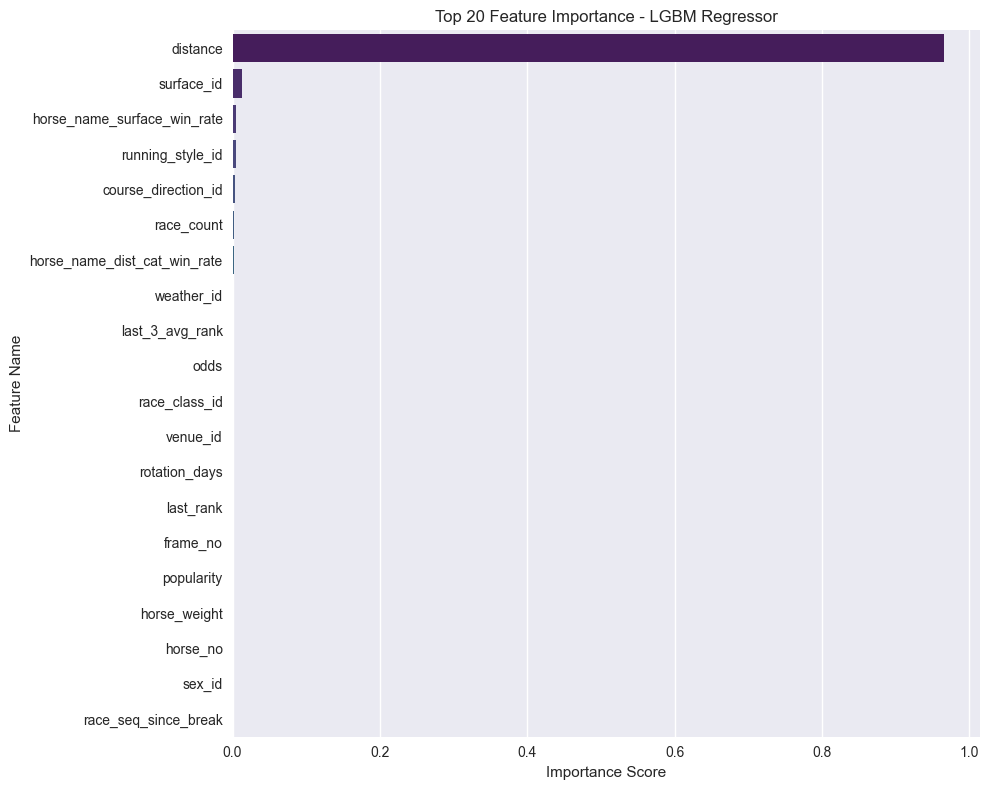

In [63]:
def plot_feature_importance(model, manual_feature_names, model_name):
    """Menampilkan grafik Feature Importance dengan Pengecekan Otomatis"""
    
    # 1. Ambil Nilai Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print(f"⚠️ Model {model_name} tidak mendukung feature importance.")
        return

    # 2. Ambil Nama Fitur (Prioritaskan dari dalam Model agar AKURAT)
    final_feature_names = manual_feature_names
    
    # Cek apakah model menyimpan nama fitur (Khusus LGBM/XGBoost/CatBoost/Sklearn terbaru)
    if hasattr(model, 'feature_name_'): # LightGBM
        final_feature_names = model.feature_name_
    elif hasattr(model, 'feature_names_in_'): # Scikit-Learn (RF, etc)
        final_feature_names = model.feature_names_in_
    
    # 3. Validasi Panjang Data
    len_imp = len(importances)
    len_feat = len(final_feature_names)
    
    if len_imp != len_feat:
        print(f"❌ ERROR MISMATCH: Model punya {len_imp} fitur, tapi list nama ada {len_feat}.")
        print("Menggunakan index angka sebagai nama fitur sementara...")
        final_feature_names = [f"Feature_{i}" for i in range(len_imp)]

    # 4. Buat DataFrame & Plot
    fi_df = pd.DataFrame({
        'Feature': final_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
    plt.title(f'Top 20 Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

# --- EKSEKUSI ---
# Load Model Regresi Terbaik Anda
model_path = 'trained_models_reg\model_XGBoost_reg.pkl' 
try:
    loaded_model = joblib.load(model_path)
    print("✅ Model Berhasil Dimuat.")
    
    # Panggil fungsi (parameter feature_cols hanya jadi cadangan)
    plot_feature_importance(loaded_model, feature_cols, "LGBM Regressor")
    
except FileNotFoundError:
    print("❌ File model tidak ditemukan.")

In [59]:
def calculate_roi(model, X_test, df_test):
    """
    Menghitung Profit/Loss jika kita bertaruh pada kuda
    yang diprediksi paling cepat (Rank 1 Prediksi) di setiap balapan.
    """
    # 1. Prediksi Waktu
    pred_time = model.predict(X_test)
    
    # 2. Gabungkan hasil prediksi ke DataFrame Test
    sim_df = df_test.copy()
    sim_df['pred_time'] = pred_time
    
    # 3. Simulasi Taruhan per Race
    results = []
    
    # Group by Race ID
    for race_id, group in sim_df.groupby('race_id'):
        # Urutkan kuda berdasarkan PREDIKSI WAKTU TERCEPAT (Ascending)
        # Kuda dengan waktu terkecil = Prediksi Juara 1
        top_pick = group.sort_values('pred_time', ascending=True).iloc[0]
        
        # Logika Taruhan (Flat Betting)
        bet_amount = 100 # Misal pasang 100 yen/rupiah
        payout = 0
        
        # Cek apakah Menang?
        is_win = (top_pick['rank'] == 1)
        
        if is_win:
            # Jika Menang: Dapat (Odds * Bet) - Modal
            # Profit bersih = (Odds - 1) * Bet
            # Tapi return total = Odds * Bet
            payout = top_pick['odds'] * bet_amount
            
        profit = payout - bet_amount
        
        results.append({
            'race_id': race_id,
            'horse_picked': top_pick['horse_name'],
            'actual_rank': top_pick['rank'],
            'odds': top_pick['odds'],
            'is_win': is_win,
            'profit': profit
        })
        
    # 4. Rekapitulasi ROI
    results_df = pd.DataFrame(results)
    
    total_races = len(results_df)
    total_wins = results_df['is_win'].sum()
    total_profit = results_df['profit'].sum()
    total_investment = total_races * 100 # Flat bet 100 per race
    roi_percentage = (total_profit / total_investment) * 100
    
    print(f"\n=== ANALISIS ROI ({model.__class__.__name__}) ===")
    print(f"Total Race       : {total_races}")
    print(f"Total Menang     : {total_wins} (Win Rate: {total_wins/total_races:.2%})")
    print(f"Total Investasi  : {total_investment:,.0f}")
    print(f"Total Profit/Loss: {total_profit:,.0f}")
    print(f"ROI              : {roi_percentage:.2f}%")
    
    return results_df

# --- EKSEKUSI ---
if 'loaded_model' in locals():
    roi_results = calculate_roi(loaded_model, X_test, test_df)


=== ANALISIS ROI (CatBoostClassifier) ===
Total Race       : 5295
Total Menang     : 128 (Win Rate: 2.42%)
Total Investasi  : 529,500
Total Profit/Loss: -159,600
ROI              : -30.14%


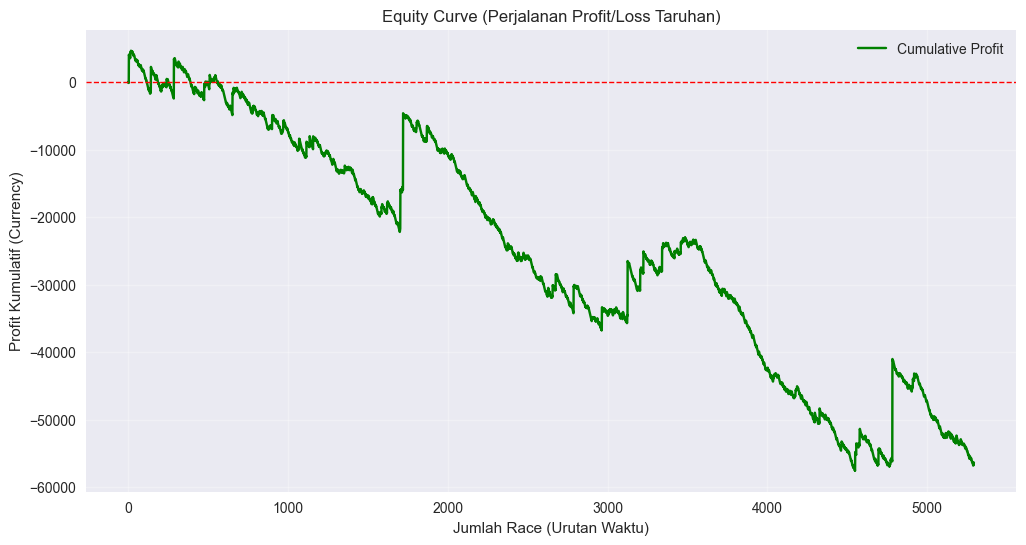

In [43]:
def plot_equity_curve(roi_results):
    # Hitung Kumulatif Profit
    roi_results['cumulative_profit'] = roi_results['profit'].cumsum()
    
    plt.figure(figsize=(12, 6))
    
    # Garis Profit
    plt.plot(roi_results['cumulative_profit'], label='Cumulative Profit', color='green')
    
    # Garis Nol (Balik Modal)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    
    plt.title('Equity Curve (Perjalanan Profit/Loss Taruhan)')
    plt.xlabel('Jumlah Race (Urutan Waktu)')
    plt.ylabel('Profit Kumulatif (Currency)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- EKSEKUSI ---
if 'roi_results' in locals():
    plot_equity_curve(roi_results)

In [62]:
def compare_model_vs_popularity(model_results_df):
    """
    Membandingkan performa Model AI vs Strategi 'Ikut-ikutan Orang Banyak' (Popularity).
    """
    print("\n=== HEAD-TO-HEAD: AI vs PUBLIC OPINION ===")
    
    # --- STRATEGI 1: MODEL AI ---
    ai_wins = model_results_df['is_win'].sum()
    ai_profit = model_results_df['profit'].sum()
    ai_roi = (ai_profit / (len(model_results_df) * 100)) * 100
    
    # --- STRATEGI 2: POPULARITY (FAVORIT) ---
    # Kita simulasi: Apa yang terjadi jika kita selalu pasang kuda Popularity 1?
    
    # Ambil data asli (kita butuh kolom popularity dan rank asli)
    # Gunakan 'test_df' yang sudah ada di memori
    pop_results = []
    
    for race_id, group in test_df.groupby('race_id'):
        # Cari kuda terpopuler (Popularity = 1)
        # Note: Kadang ada 2 kuda pop 1, kita ambil yang pertama saja
        fav_horse = group[group['popularity'] == 1]
        
        if not fav_horse.empty:
            pick = fav_horse.iloc[0]
            
            # Cek Menang/Kalah
            is_win = (pick['rank'] == 1)
            profit = (pick['odds'] * 100) - 100 if is_win else -100
            
            pop_results.append({
                'race_id': race_id,
                'is_win': is_win,
                'profit': profit
            })
            
    pop_df = pd.DataFrame(pop_results)
    
    pop_wins = pop_df['is_win'].sum()
    pop_profit = pop_df['profit'].sum()
    pop_roi = (pop_profit / (len(pop_df) * 100)) * 100
    
    # --- TAMPILKAN PERBANDINGAN ---
    comparison = pd.DataFrame({
        'Metric': ['Total Races', 'Win Count', 'Win Rate', 'Net Profit', 'ROI'],
        '🤖 AI Model': [
            len(model_results_df),
            ai_wins,
            f"{ai_wins/len(model_results_df):.2%}",
            f"{ai_profit:,.0f}",
            f"{ai_roi:.2f}%"
        ],
        '👥 Public (Popularity 1)': [
            len(pop_df),
            pop_wins,
            f"{pop_wins/len(pop_df):.2%}",
            f"{pop_profit:,.0f}",
            f"{pop_roi:.2f}%"
        ]
    })
    
    display(comparison)
    
    # Kesimpulan Otomatis
    if ai_profit > pop_profit:
        print("\n🏆 KESIMPULAN: Model AI Anda LEBIH PINTAR daripada pasar!")
    else:
        print("\n⚠️ KESIMPULAN: Model AI masih kalah dengan pasar. Perlu tuning lagi.")

# --- EKSEKUSI ---
# Pastikan 'roi_results' sudah ada (dari cell sebelumnya)
if 'roi_results' in locals():
    compare_model_vs_popularity(roi_results)


=== HEAD-TO-HEAD: AI vs PUBLIC OPINION ===


,Metric,🤖 AI Model,👥 Public (Popularity 1)
0,Total Races,5295,5285
1,Win Count,128,1711
2,Win Rate,2.42%,32.37%
3,Net Profit,"-159,600","-109,140"
4,ROI,-30.14%,-20.65%



⚠️ KESIMPULAN: Model AI masih kalah dengan pasar. Perlu tuning lagi.
